<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/GAN_Ising_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [2]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat

#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
labels = np.loadtxt('ising2_label.dat')

--2020-05-30 16:45:16--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  11.8MB/s    in 1.5s    

2020-05-30 16:45:18 (11.8 MB/s) - ‘ising2_conf.dat’ saved [19060775/19060775]

--2020-05-30 16:45:19--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K   310KB/s    in 0.3s    

2020-05-30 16:45:20 (310 KB/s) - ‘ising2_label.dat’ saved [81025/810

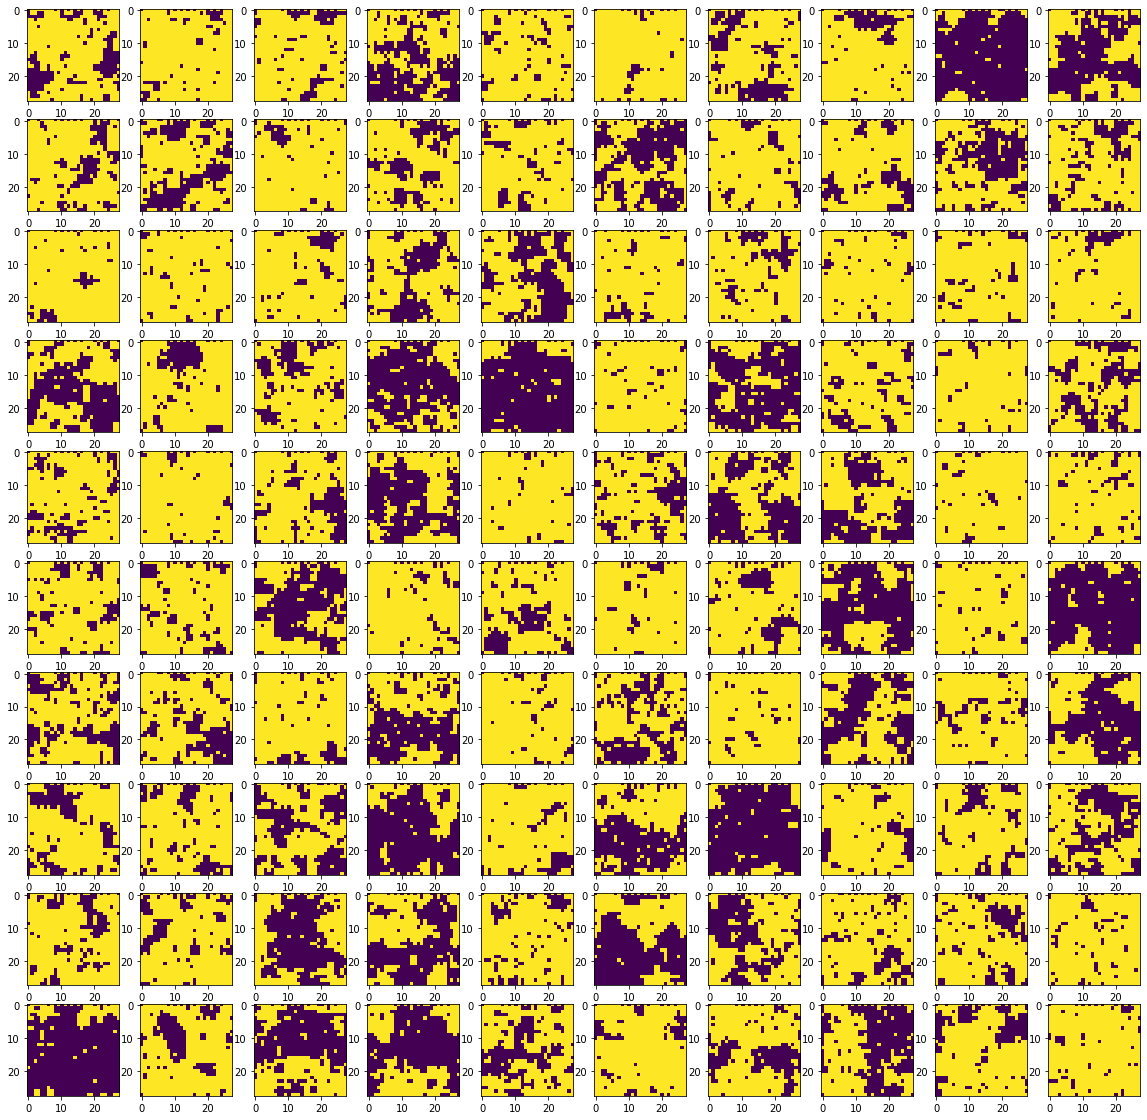

In [3]:
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(-1,28,28,1).astype('float32')

cri_sele = ((labels >= 2) & (labels <= 2.5))
cri_data = data[cri_sele]

n, m = 10, 10
fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(cri_data[i*m+j].reshape(28, 28))

train_dataset = tf.data.Dataset.from_tensor_slices(data)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(32)

In [0]:
IMG_SHAPE = (28, 28, 1)

In [22]:
def get_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model
d_model = get_discriminator_model()
d_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [23]:
# Generator: campiona un vettore latente e genera un immagine

# usa upsampling (Conv2DTranspose) per passare da z -> immagine
# Size of latent vector (la dimensione del vettore latente z)

latent_dim = 128

def get_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(128,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation=tf.tanh))
    return model

g_model = get_generator_model()
g_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12544)             1605632   
_________________________________________________________________
batch_normalization_18 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 7, 7, 128)         524288    
_________________________________________________________________
batch_normalization_19 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 7, 7, 128)        

In [0]:
# Modello DCGAN: implementiamo un keras.Model custom
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # funzione per la compilazione
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple): #verifica che l'input isa una python tuple (numpy tensor)
            real_images = real_images[0]

        # 1) campiona un batch di punti random nello spazio latente: z
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2) usa il generatore per creare dai vettori latenti immagini fake: immagine = G(z)
        generated_images = self.generator(random_latent_vectors)
        #print(generated_images.shape, real_images.shape, flush=True)
        # 3) combina le immagini fake con quelle reali 
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4) assegna le label corrette (fae vs reale)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # 5) Trucco per diminuire la probabilità di collasso della rete (si aggiunge un po' di rumore random alle label) 
        labels += 0.2 * tf.random.uniform(tf.shape(labels))

        # 6) Training del discriminatore D
        with tf.GradientTape() as tape: #autograd
            predictions = self.discriminator(combined_images) #predizione = D(immagini)
            d_loss = self.loss_fn(labels, predictions) #calcolo loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #backprop
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights) #aggiornamento pesi
        )

        # 7) campiona un nuovo batch di punti dello spazio latente: z
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 8) crea un vettore di label corrispondenti a tutte immagii reali
        misleading_labels = tf.zeros((batch_size, 1))

        # 9) Training del generatore (non si devono aggiornare ovviamente i pesi del discriminatore)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors)) #predizione = D(G(z))
            g_loss = self.loss_fn(misleading_labels, predictions) #calcolo loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) #backprop
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) #aggiornamento pesi

        return {"d_loss": d_loss, "g_loss": g_loss}

In [0]:
# custom callback to save generated images peridoically during training
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128, norma=1.0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.norma = norma

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * self.norma

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img2 = keras.preprocessing.image.array_to_img(img)
            img2.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            img = img.reshape((28*28))
            np.savetxt("generated_img_{i}_{epoch}.dat".format(i=i, epoch=epoch), img)

In [0]:
# Training della GAN

# Ottimizzatori di G e D
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# Loss function
gan_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Epochs
EPOCHS = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=latent_dim, norma=255)

# Istanziamento modello
gan = DCGAN(discriminator=d_model, generator=g_model, latent_dim=latent_dim)

# Compilazione
gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    loss_fn=gan_loss,
)

In [0]:
# Start training
gan.fit(train_dataset, epochs=EPOCHS, callbacks=[cbk], batch_size=64)

Epoch 1/20
157/157 [==============================] - 6s 37ms/step - d_loss: 0.4132 - g_loss: 1.2829
Epoch 2/20
157/157 [==============================] - 5s 35ms/step - d_loss: 0.3103 - g_loss: 2.3866
Epoch 3/20
157/157 [==============================] - 5s 34ms/step - d_loss: 0.3406 - g_loss: 2.4289
Epoch 4/20
157/157 [==============================] - 5s 34ms/step - d_loss: 0.3022 - g_loss: 3.7921
Epoch 5/20
157/157 [==============================] - 5s 35ms/step - d_loss: 0.1519 - g_loss: 5.9478
Epoch 6/20
157/157 [==============================] - 5s 35ms/step - d_loss: 0.2651 - g_loss: 3.3960
Epoch 7/20
157/157 [==============================] - 5s 35ms/step - d_loss: 0.3654 - g_loss: 2.5201
Epoch 8/20
157/157 [==============================] - 5s 35ms/step - d_loss: 0.4053 - g_loss: 2.1018
Epoch 9/20
157/157 [==============================] - 5s 35ms/step - d_loss: 0.4279 - g_loss: 1.9723
Epoch 10/20
151/157 [===========================>..] - ETA: 0s - d_loss: 0.4190 - g_loss: 1

In [0]:
n, m = 10, 10
random_latent_vectors = tf.random.normal(shape=(n*m, latent_dim))
generated_images = gan.generator(random_latent_vectors)

fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(generated_images[n*i+j].numpy().reshape((28, 28)))